# Extraction selon une emprise

Nous nous intéressons souvent à une zone d'intéret qui ne coincide par forcéement avec le jeu de données original.

**filters.crop** (PDAL) permet de découper le nuage de points de différentes manières :

1. Selon une bounding box (2d ou 3d)
1. Selon un polygon
1. Selon un point et une distance

https://pdal.io/en/latest/stages/filters.crop.html

Dans ce notebook, nous allons extraire les points selon un polygone.

## Emprise des données

Commençons par afficher l'emprise des données en entrée.

In [1]:
%%time
import subprocess, json, shapely, pathlib, pyproj, IPython.display, ipyleaflet
from shapely.geometry import Polygon
from ipyleaflet import Map, WKTLayer
from shapely.ops import transform


#chemin du fichier source
datasource = pathlib.Path.cwd() /'data'/'input'
output = pathlib.Path.cwd() /'data'/'output'
file = '2560_1145.las'

#exécution de pdal info pour accéder aux métadonnées du fichier 
result = subprocess.run(['pdal', 'info', datasource/file],
                        stderr = subprocess.PIPE,  # stderr and stdout get
                        stdout = subprocess.PIPE)  # captured as bytestrings

# décode du stdout en bytestring et parsage dans un dictionnaire
json_result = json.loads(result.stdout.decode())

#création d'un poylogne selon l'emprise du fichier en entrée
coords = json_result['stats']['bbox']['native']['boundary']['coordinates']
bbox_poly = Polygon(*coords)


#affichage de l'emrpise sur ipyleaflet
wsg84 = 'epsg:4326'
ch1903plus= 'epsg:2056'
project  = pyproj.Transformer.from_crs(ch1903plus, wsg84, always_xy=True).transform
wsg84_bbox_poly=transform(project, bbox_poly)
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=14)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
m

CPU times: total: 234 ms
Wall time: 12.2 s


Map(center=[46.45966150948135, 6.9244668994876495], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Nous voyons donc ci-dessus l'emrpise du nuage de points. De manière plus précise, c'est l'emprise rectangulaire définie par les coordonnées minimales et maximales des points.

# Extraction des points

Nous souhaitons traiter une zone en particulier. Je vous propose de saisir cette zone via l'outil **Draw a polygon** un polygone de la zone à extraire.

In [2]:
from pyproj import Transformer
m = ipyleaflet.Map(center=(wsg84_bbox_poly.centroid.y, wsg84_bbox_poly.centroid.x), zoom=16)
wlayer = WKTLayer( wkt_string=wsg84_bbox_poly.wkt,)
m.add_layer(wlayer)
dc = ipyleaflet.DrawControl()
m.add_control(dc)
m

Map(center=[46.45966150948135, 6.9244668994876495], controls=(ZoomControl(options=['position', 'zoom_in_text',…

Une fois le polygone tracé avec l'outil polygone, exécuter la cellule suivante.

POLYGON ((2560639.7875342774 1145575.0759591036, 2560474.4995796713 1145510.460317997, 2560551.1709253914 1145381.7804349845, 2560714.8470236994 1145457.970160915, 2560639.7875342774 1145575.0759591036))


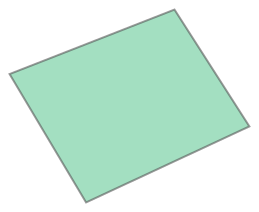

In [9]:
from pyproj import transformer
import shapely
transformer = Transformer.from_crs(wsg84, ch1903plus)
coords_draw = [transformer.transform(y,x) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
polygon_draw = shapely.geometry.Polygon(coords_draw)
print(polygon_draw.wkt)
IPython.display.display(polygon_draw)

Ci-dessus, le polygone que nous avons dessiné.

Via PDAL, nous allons **filtrer** les points du nuage d'origine en fonction du poylgone que nous venons de déterminer.

In [13]:
import pdal
polygon_draw_bounds = polygon_draw.bounds
cropper = {
    "pipeline": [str(datasource/file),
        {   "type":"filters.crop",
            'bounds':str(([polygon_draw_bounds[0], polygon_draw_bounds[2]],[polygon_draw_bounds[1], polygon_draw_bounds[3]]))},
        {   "type":"filters.crop",
            'polygon':polygon_draw.wkt
        },
    
        {   "type":"writers.las",
            "filename": str(output)+"\\"+"cloud_crop.laz"
        },
    ]}
pipeline = pdal.Pipeline(json.dumps(cropper))
#pipeline.validate()
%time n_points = pipeline.execute()

print('Pipeline selected {} points ({:.1f} pts/m2)'.format(n_points, n_points/polygon_draw.area))

CPU times: total: 8.47 s
Wall time: 8.48 s
Pipeline selected 440678 points (17.2 pts/m2)


Voici le résultat, on constate que le fichier ne contient plus que les points contenant dans le polygone dessiné.

![crop](data/img/pdal_filterscrop_intensity.png)